In [2]:
import os
import tqdm
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
%matplotlib inline


def notify(title, subtitle='', message=''):
    t = '-title {!r}'.format(title)
    s = '-subtitle {!r}'.format(subtitle)
    m = '-message {!r}'.format(message)
    os.system('terminal-notifier {}'.format(' '.join([m, t, s])))

In [3]:
def is_vowel(ch):
    return ch.lower() in 'уеыаоэёяию'

def is_consonant(ch):
    return ch.lower() in 'йцкнгшщзхъфвпрлджчсмтьб'

def num_vowels(string):
    ans = 0
    for c in string:
        if is_vowel(c):
            ans += 1
    return ans

def is_caps(string):
    """
    RETURNS
    -------
    int : {0,1,2}
        0 - all chars are caps
        1 - only first char is caps
        2 - all chars are lower
    
    """
    if all(list(map(lambda x: x == x.upper(), string))):
        return 0
    elif string[0] == string[0].upper():
        return 1
    else:
        return 2


alphabet = ''.join([chr(i) for i in range(ord('а'), ord('я')+1)])
ch_gram_alphabet = []

for i in alphabet:
    for j in alphabet:
        ch_gram_alphabet.append(i + j)

print(len(ch_gram_alphabet))

print(ch_gram_alphabet.index('ля'))


def index_of_last_pair(string):
    return ch_gram_alphabet.index(string[-2:].lower())

1024
383


In [4]:
%%time
test = pd.read_csv("linear_test.txt", header=None, names=['x'])
train = pd.read_csv("linear_train.txt", header=None, names=['x', 'y'])
train_y = train['y']
train = train.drop(['y'], axis=1)

test['x'] = list(map(lambda x: x.replace('ё', 'е'), test['x']))
train['x'] = list(map(lambda x: x.replace('ё', 'е'), train['x']))

ch_gram_alphabet = list(set.union(set(ch_gram_alphabet), set(list(map(lambda x: x[-2:].lower(), train['x']))), set(list(map(lambda x: x[-2:].lower(), test['x'])))))
print(len(ch_gram_alphabet))

# train['length'] = list(map(lambda x: len(x), train['x']))
train['vowels'] = list(map(lambda x: num_vowels(x), train['x']))
train['caps'] = list(map(lambda x: is_caps(x), train['x']))
train['last'] = list(map(lambda x: ord(x[-1]), train['x']))
train['first'] = list(map(lambda x: ord(x[0]), train['x']))
train['last_pair'] = list(map(lambda x: index_of_last_pair(x), train['x']))

# test['length'] = list(map(lambda x: len(x), test['x']))
test['vowels'] = list(map(lambda x: num_vowels(x), test['x']))
test['caps'] = list(map(lambda x: is_caps(x), test['x']))
test['last'] = list(map(lambda x: ord(x[-1]), test['x']))
test['first'] = list(map(lambda x: ord(x[0]), test['x']))
test['last_pair'] = list(map(lambda x: index_of_last_pair(x), test['x']))

sample_submission = pd.read_csv("linear_ans_example.txt")

sum(train_y)/len(train_y)

1117
CPU times: user 6.81 s, sys: 98.6 ms, total: 6.91 s
Wall time: 7.07 s


# First Stupid Predictions

0.898449826444


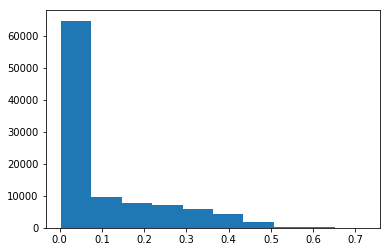

True


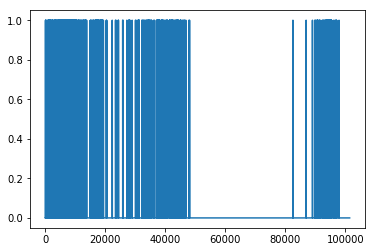

[('Абдулова', 1), ('Абдуловым', 1), ('Абиева', 1), ('Абрамцева', 1), ('Авдеева', 1), ('Аверинцева', 1), ('Аверкиева', 1), ('Агапова', 1), ('Агентства', 0), ('Адмиралтейства', 0), ('Азизова', 1), ('Азизовым', 1), ('Азимовым', 1), ('Айова', 0), ('Айтматовым', 1), ('Акаева', 1), ('Акбарова', 1), ('Акбулатова', 1), ('Акимова', 1), ('Аккредитива', 0), ('Аксенова', 1), ('Аксеновым', 1), ('Аксеновым', 1), ('Акулова', 1), ('Александрова', 1), ('Алиевым', 1), ('Алферовым', 1), ('Алферова', 1), ('Алябьева', 1), ('Аманова', 1), ('Аминова', 1), ('Амирова', 1), ('Амирханова', 1), ('Ангелова', 1), ('Андреева', 1), ('Андриянова', 1), ('Андронова', 1), ('Андропова', 1), ('Аникеева', 1), ('Анкудинова', 1), ('Антонова', 1), ('Антоновым', 1), ('Аракелова', 1), ('Арбатова', 1), ('Аргунова', 1), ('Арева', 0), ('Арзуманова', 1), ('Аристархова', 1), ('Арсеньева', 1), ('Арустамова', 1), ('Архиповым', 1), ('Аскерова', 1), ('Атаева', 1), ('Ахадова', 1), ('Ахмадовым', 1), ('Ашмариным', 1), ('Ашурова', 1), ('Аяцк

In [6]:
%%time
clf = XGBClassifier()

train_x = train.drop(['x'], axis=1)
clf.fit(train_x, train_y)

print(accuracy_score(train_y, clf.predict(train_x)))

preds = clf.predict(train_x)
preds_prob = clf.predict_proba(train_x)

plt.hist(preds_prob[:, 1])
plt.show()
print(any(preds))

plt.plot(preds)
plt.show()

print([(train.iloc[i]['x'], train_y[i]) for i in [i for i, x in enumerate(preds) if x == 1]])

# Some Research...

In [323]:
# sample_submission['Answer'] = clf.predict_proba(test.drop(['x'], axis=1))[:, 1]
# [(test.iloc[i]['x'], sample_submission.iloc[i]['Answer']) for i in [i for i, x in enumerate(sample_submission['Answer']) if x > 0.5]]

In [11]:
print('In Train Data:', set((''.join(train['x'])).lower()))

In Train Data: {'/', '.', 'х', 'н', 'ѐ', '7', 'ь', 'я', 'а', "'", '2', 'о', 'щ', '4', 'ó', 'и', 'ё', '“', 'ф', '·', 'г', 'э', '”', '’', '-', ' ', 'м', 'л', 'п', 'ж', 'т', 'е', '«', 'é', 'у', 'к', 'ц', 'с', 'б', 'ч', 'ш', 'ю', '3', 'р', 'ы', 'ъ', 'д', 'в', '»', 'й', 'з'}


In [12]:
print('In Test Data:', set((''.join(test['x'])).lower()))

In Test Data: {'/', '.', 'х', 'н', '"', 'ë', '`', '7', 'ô', 'ь', 'я', 'а', "'", '2', '\\', 'о', 'щ', 'ó', 'и', '\xa0', 'ё', '“', 'ф', '0', 'г', 'э', '’', ' ', '-', 'м', 'л', 'п', '&', 'ж', 'т', 'е', 'á', '«', '1', 'é', 'у', 'к', 'ц', 'с', 'б', 'ч', 'ю', 'ш', '3', 'р', 'ы', 'ъ', 'д', 'в', '»', 'й', 'з'}


In [26]:
def get_vector(ch_gram, gram_alphabet):
    ch_gram = ch_gram.lower()
    tmp = np.zeros(len(gram_alphabet))
    if ch_gram in gram_alphabet:
        tmp[gram_alphabet.index(ch_gram)] = 1
    return tmp
        
    
def string_to_vec(string, gram_alphabet):            
    string = string.lower()
    grams = make_ngrams(string, 2)
    tmp_ans = np.zeros(len(gram_alphabet))
    for gram in grams:
        tmp_ans += get_vector(gram, gram_alphabet)
    return tmp_ans / len(grams)


def make_ngrams(string, n=2):
    string = string.lower()
    return [string[i:i+n] for i in range(len(string) - n + 1)]

In [27]:
make_ngrams('Аарон', 2)

['аа', 'ар', 'ро', 'он']

In [101]:
mat = np.random.uniform(0, 1, len(ch_gram_alphabet))

In [102]:
np.dot(mat, string_to_vec('квартира', ch_gram_alphabet))

0.54723693921725847

In [28]:
string_to_vec('квартира', ch_gram_alphabet)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [29]:
%%time
new_train = pd.DataFrame(columns=np.concatenate((train.columns.values, np.arange(len(ch_gram_alphabet)))))
new_train

res = []

for i in tqdm.tqdm(range(len(train))):
    res.append(np.concatenate((train.iloc[i], string_to_vec(train.iloc[i]['x'], gram_alphabet=ch_gram_alphabet))))
    
new_train = pd.DataFrame(data=res, columns=np.concatenate((train.columns.values, np.arange(len(ch_gram_alphabet)))))
    
notify('kek_1')

100%|██████████| 101392/101392 [01:02<00:00, 1622.64it/s]


CPU times: user 1min 46s, sys: 25.8 s, total: 2min 12s
Wall time: 2min 29s


In [30]:
tmp = []
for col in new_train.columns.values[1:]:
    tmp.append(np.isnan(new_train[col]))
notify('Checked!')

In [115]:
min(list(map(lambda x: len(x), train['x'])))

1

In [23]:
train_y = train_y.iloc[[en for en, x in enumerate(list(map(lambda x: len(x), train['x']))) if x > 1]]
train = train.iloc[[en for en, x in enumerate(list(map(lambda x: len(x), train['x']))) if x > 1]]

In [31]:
list(tmp[5]).count(True)

0

In [32]:
ans = []
for x in tmp:
    ans.append(any(x))

In [33]:
any(ans)

False

In [38]:
logreg = LogisticRegression()

In [39]:
%%time
logreg.fit(new_train.drop(['x'], axis=1), train_y)
notify('Trained!')

CPU times: user 3.89 s, sys: 1.41 s, total: 5.3 s
Wall time: 5.92 s


In [40]:
log_preds = logreg.predict(new_train.drop(['x'], axis=1))

(array([ 101289.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,     103.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

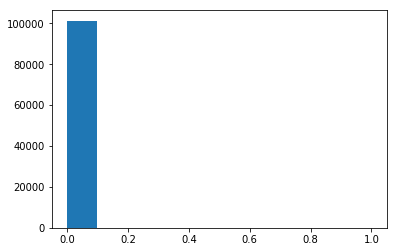

In [41]:
plt.hist(log_preds)

In [42]:
accuracy_score(train_y, log_preds)

0.89498185261164587

In [43]:
sum(log_preds)

103

In [44]:
%%time
clf = XGBClassifier(max_depth=20)
clf.fit(new_train.drop(['x'], axis=1), train_y)
notify('Trained!')

CPU times: user 30min 36s, sys: 13 s, total: 30min 49s
Wall time: 9min 1s


In [45]:
%%time
preds = clf.predict(new_train.drop(['x'], axis=1))

print(sum(train_y)/len(train_y))
print(sum(preds)/len(preds))

# it was 0.90675291890186183 with 0.87 on public leaderboard
# it was 0.95879023351214898 with 0.92 on public leaderboard
# it was 0.968493609972 with 0.92 on public leaderboard with 'length'
# it was 0.965722625434 with 0.92 on public leaderboard without 'length'
print(accuracy_score(train_y, preds))

0.104909657567
0.0711989111567
0.960450528641
CPU times: user 8.33 s, sys: 4.45 s, total: 12.8 s
Wall time: 10.5 s


In [52]:
short_indices = [en for en, x in enumerate(list(map(lambda x: len(x), test['x']))) if x == 1]

In [53]:
%%time

new_test = pd.DataFrame(columns=np.concatenate((test.columns.values, np.arange(len(ch_gram_alphabet)))))
new_test

res_test = []

for i in tqdm.tqdm(range(len(test))):
    res_test.append(np.concatenate((test.iloc[i], string_to_vec(test.iloc[i]['x'], ch_gram_alphabet))))
    
new_test = pd.DataFrame(data=res_test, columns=np.concatenate((test.columns.values, np.arange(len(ch_gram_alphabet)))))

notify('kek_2')

100%|██████████| 188920/188920 [02:08<00:00, 1472.50it/s]


CPU times: user 3min 21s, sys: 59.4 s, total: 4min 21s
Wall time: 4min 48s


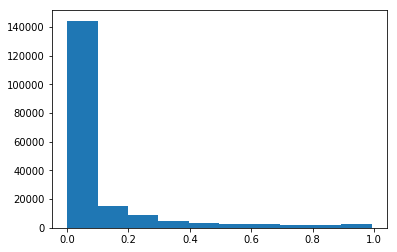

CPU times: user 16.3 s, sys: 10.2 s, total: 26.5 s
Wall time: 24.4 s


In [54]:
%%time
sample_submission['Answer'] = clf.predict_proba(new_test.drop(['x'], axis=1))[:, 1]

plt.hist(sample_submission['Answer'])
plt.show()

In [55]:
sample_submission.iloc[short_indices]

,Id,Answer
18273,18273,0.015706
27619,27619,0.017368
27620,27620,0.026948
44301,44301,0.017020
73884,73884,0.016186
79637,79637,0.019224
79638,79638,0.027052
97517,97517,0.040561
97518,97518,0.077840
106007,106007,0.021976


In [56]:
[(test.iloc[i]['x'], sample_submission.iloc[i]['Answer']) for i in [i for i, x in enumerate(sample_submission['Answer']) if x > 0.5]]

[('Абаев', 0.78419143),
 ('Абаева', 0.96576703),
 ('Абаевым', 0.97374445),
 ('Абакумова', 0.9820562),
 ('АБАКУМОВА', 0.96878183),
 ('Абакумову', 0.97245252),
 ('Абакумовым', 0.97630423),
 ('Абалкин', 0.89699465),
 ('Абаринов', 0.87123048),
 ('Абасов', 0.67403376),
 ('Аббасова', 0.97802162),
 ('Аббасову', 0.9792183),
 ('Аббот', 0.55777025),
 ('Абдрахманова', 0.95944816),
 ('Абдулин', 0.74259007),
 ('Абдулина', 0.7903474),
 ('Абдуллаев', 0.95320106),
 ('Абдуллаева', 0.94042373),
 ('Абдуллаеву', 0.91547787),
 ('Абдуллаевым', 0.95384574),
 ('Абдуллина', 0.79693031),
 ('Абдулов', 0.70403969),
 ('Абдулов', 0.70403969),
 ('Абелева', 0.95388371),
 ('Абелевым', 0.91503578),
 ('Абердин', 0.85827315),
 ('Абердина', 0.81724346),
 ('Абердине', 0.70233345),
 ('Абердину', 0.75876528),
 ('Абернати', 0.63302362),
 ('Абзацев', 0.66507733),
 ('Абидин', 0.59376836),
 ('Абиев', 0.80822527),
 ('Абиевым', 0.96514314),
 ('Абилов', 0.76528209),
 ('Аблязов', 0.65620333),
 ('Абнер', 0.68332589),
 ('Абнера', 0.54

In [57]:
sample_submission.to_csv("submission.csv", sep=',', index=False)
notify('Done with submission!')

In [128]:
%%time
lrs = LogisticRegression()

lrs.fit(new_train.drop(['x','vowels', 'caps', 'last', 'first', 'last_pair'], axis=1), train_y)
notify('LR Trained!')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').